In [1]:
import numpy as np
import pandas as pd
import pymysql
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import requests
import itertools
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
conn = pymysql.connect(host='localhost', user='root', password='Sk1ttles', db='nba_stats_prod', autocommit=True)

In [563]:
train = """
select basic.player_id,
       box_view.team,
       box_view.game_hash,
       box_view.game_date,
      -- box_view.home_away,
       basic.pts,
       basic.minutes_played,
       basic.fga,
       basic.3pa,
       basic.orb,
       basic.trb,
       basic.ast,
       basic.stl,
       basic.blk,
       basic.tov,
       basic.pf,
       adv.turnover_pct,
       adv.usage_pct,
       a_stats.pace,
       a_stats.pie,
       adv.offensive_rating,
       reg_avg.fg_a as tot_fg_a,
       reg_avg.3p_a as tot_3p_a,
       reg_avg.ft_a as tot_ft_a,
       reg_avg.reb as tot_reb,
       reg_avg.ast as tot_ast,
       reg_avg.blk as tot_blk,
       reg_avg.stl as tot_stl,
       reg_avg.pf as tot_pf,
       reg_avg.`TO` as tot_to,
       opp_team_pts.opp_pts,
       opp_team_pts.diff,
       misc.FBPS,
       misc.second_chance_pts

from (

     select b.game_hash,
            b.home_team as team,
            b.game_date,
            team.team_id as away_id,
            lu.season
     from box_score_map as b
     inner join game_date_lookup as lu on b.game_date = lu.day
     inner join team_info as team on b.away_team = team.team
     where b.game_date < current_date and
           lu.season > 2011 -- 2007 CV score = 0.90605650317383979

     ) as box_view

inner join player_team_map as play_m on ( (box_view.team = play_m.team) and (
box_view.season = play_m.season) )
inner join basic_box_stats as basic on ( (box_view.game_hash = basic.game_hash) and (
play_m.player_id = basic.player_id) )
inner join advanced_box_stats as adv on ( (box_view.game_hash = adv.game_hash) and (
play_m.player_id = adv.player_id) )
inner join team_advanced_boxscore_stats as a_stats on ( (box_view.game_hash = a_stats.game_hash) and (box_view.team = a_stats.team) )
left outer join RegularSeasonAverages as reg_avg on ( (basic.player_id = reg_avg.player_id) and (box_view.season -1 = reg_avg.season) )
inner join points as opp_team_pts on box_view.away_id = opp_team_pts.team_id and box_view.season -1 = opp_team_pts.season
inner join team_misc_boxscore_stats as misc on ( (box_view.game_hash = misc.game_hash) and (box_view.team = misc.team) )
order by basic.player_id,
         box_view.game_date asc;

"""

In [564]:
df = pd.read_sql(sql=train, con=conn, index_col=None)

In [565]:
def time_convert(minutes_played):
    time_list = minutes_played.split(':')
    try:
        return ((int(time_list[0]) * 60) + int(time_list[1]))
    except ValueError:
        return 0

In [566]:
def concat_drop(df, dummy_var_col, drop_list):
    for field in dummy_var_col:
        df = pd.concat([df, gen_dummby_var(df, field)], axis=1)
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [567]:
def gen_dummby_var(df, column):
    return pd.get_dummies(df[column], drop_first=True)

In [568]:
#### finding number of days in between games on player level 

In [569]:
#df['game_date'] = pd.to_datetime(df['game_date'])
#df.head()

In [570]:
df.loc[:, 'minutes_played'] = df.loc[:, 'minutes_played'].apply(time_convert)

In [571]:
df['days_of_rest'] = df.game_date.diff().dt.days.fillna(0).astype(int)
df[df['days_of_rest'] < 0] = 0

In [572]:
df.drop([ 'player_id', 'team', 'game_hash', 'game_date'], axis=1, inplace=True)
clean_df = df[df['minutes_played'] >= 720]
#clean_df = concat_drop(df[df['minutes_played'] >= 900], ['home_away'], [ 'player_id', 'team', 'game_hash', 'game_date'])

In [573]:
#clean_df.drop('Home', inplace=True, axis=1)
clean_df.head()
#group_df = clean_df.groupby(['game_date','team'])
#group_df.head()

,pts,minutes_played,fga,3pa,orb,trb,ast,stl,blk,tov,...,tot_ast,tot_blk,tot_stl,tot_pf,tot_to,opp_pts,diff,FBPS,second_chance_pts,days_of_rest
5,0,815,2,1,0,1,0,0,0,2,...,NaN,NaN,NaN,NaN,NaN,105.0,-3.1,25,16,2
13,2,987,5,3,0,2,1,0,0,1,...,NaN,NaN,NaN,NaN,NaN,98.4,1.6,23,12,5
16,6,1233,4,3,0,6,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,92.9,10.6,21,28,2
17,5,1484,4,3,1,4,0,0,2,1,...,NaN,NaN,NaN,NaN,NaN,95.9,1.8,19,6,2
18,5,808,6,3,3,5,2,0,0,0,...,NaN,NaN,NaN,NaN,NaN,100.2,4.3,12,22,16


In [574]:
#for group in group_df.groups:
 #   print(group)

In [575]:
clean_df = clean_df.fillna(0)

In [576]:
x = clean_df.loc[:, 'minutes_played':]
y = clean_df.loc[:, 'pts']

In [577]:
X_train, X_test, y_train, y_test = train_test_split(clean_df.loc[:, 'minutes_played':], clean_df.loc[:, 'pts'], test_size=.33)

In [578]:
lm = LinearRegression()

In [579]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [580]:
predictions = lm.predict(X_test)

Text(0,0.5,'Predicted Y')

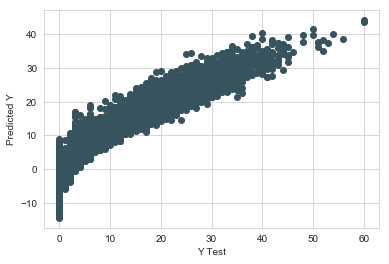

In [581]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

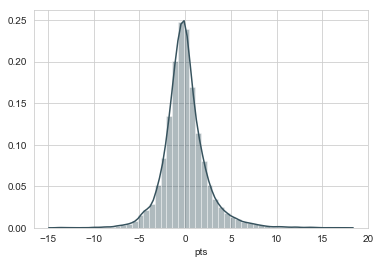

In [582]:
sns.distplot((y_test-predictions),bins=50);

In [583]:
coeffecients = pd.DataFrame(lm.coef_,X_test.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
minutes_played,0.003391
fga,0.731427
3pa,0.063373
orb,-0.416279
trb,0.037910
ast,-0.323821
stl,0.017342
blk,0.041965
tov,0.014034
pf,0.001017


In [584]:
lm.score(X_test, y_test)

0.90189665855089474

In [502]:
### Experimenting with Lasso regression

In [503]:
lasso = Lasso(alpha=0.0023101297000831605)  #Home: 0.00174333 - 0.00221222

In [504]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.0023101297000831605, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [505]:
predictions = lasso.predict(X_test)

Text(0,0.5,'Predicted Y')

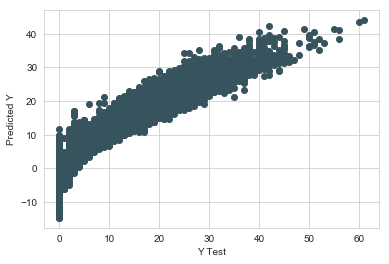

In [506]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

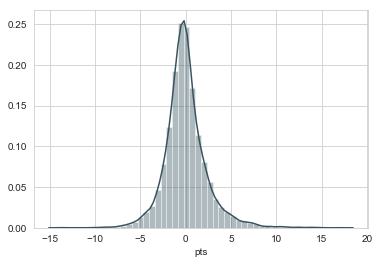

In [507]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')
sns.distplot(y_test-predictions, bins=50)

In [508]:
lasso.score(X_test, y_test)

0.90499838153847245

In [509]:
coeffecients = pd.DataFrame(lasso.coef_,X_test.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
minutes_played,0.003458
fga,0.724111
3pa,0.056322
orb,-0.400927
trb,0.034243
ast,-0.312361
stl,0.019924
blk,0.015208
tov,0.000000
pf,-0.000000


In [510]:
#### Using Lasso cross-validation model

In [511]:
lasso_cv = LassoCV()

In [512]:
lasso_cv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [513]:
predictions_cv = lasso_cv.predict(X_test)

Text(0,0.5,'Predicted Y')

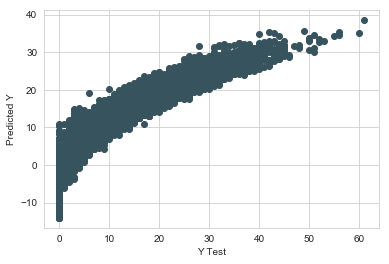

In [514]:
plt.scatter(y_test,predictions_cv)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

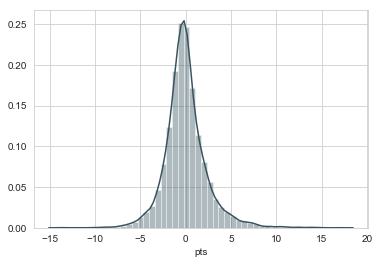

In [515]:
sns.distplot(y_test-predictions, bins=50)

In [516]:
lasso_cv.score(X_test, y_test)

0.87151947318590561

In [517]:
coeffecients = pd.DataFrame(lasso.coef_,X_test.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
minutes_played,0.003458
fga,0.724111
3pa,0.056322
orb,-0.400927
trb,0.034243
ast,-0.312361
stl,0.019924
blk,0.015208
tov,0.000000
pf,-0.000000


In [518]:
### optimizing alpha value in Lasso regression

In [585]:
alphas = np.logspace(-4, -1, 50)
#alphas = np.linspace(.001, .999, 100) #0.00464159
alphas

array([ 0.0001    ,  0.00011514,  0.00013257,  0.00015264,  0.00017575,
        0.00020236,  0.000233  ,  0.00026827,  0.00030888,  0.00035565,
        0.00040949,  0.00047149,  0.00054287,  0.00062506,  0.00071969,
        0.00082864,  0.0009541 ,  0.00109854,  0.00126486,  0.00145635,
        0.00167683,  0.0019307 ,  0.002223  ,  0.00255955,  0.00294705,
        0.00339322,  0.00390694,  0.00449843,  0.00517947,  0.00596362,
        0.00686649,  0.00790604,  0.00910298,  0.01048113,  0.01206793,
        0.01389495,  0.01599859,  0.0184207 ,  0.02120951,  0.02442053,
        0.02811769,  0.03237458,  0.03727594,  0.04291934,  0.04941713,
        0.05689866,  0.06551286,  0.0754312 ,  0.08685114,  0.1       ])

In [586]:
scores = np.empty_like(alphas)

In [587]:
for i, a in enumerate(alphas):
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    scores[i] = lasso.score(X_test, y_test)

In [588]:
lasso_cv = LassoCV(alphas=alphas)
lasso_cv.fit(x, y)
cv_score = lasso_cv.score(x, y)
cv_alpha = lasso_cv.alpha_
cv_alpha, cv_score, lasso_cv.coef_, lasso_cv.intercept_

(0.0059636233165946424,
 0.90444314333874742,
 array([  3.43985744e-03,   7.18664298e-01,   6.67199938e-02,
         -4.03138049e-01,   3.83648519e-02,  -3.17892278e-01,
          1.68309333e-02,   3.41314014e-02,  -0.00000000e+00,
          0.00000000e+00,   7.98901459e-02,   2.85385728e-01,
          6.56510271e-02,   5.42638646e-03,   9.57939755e-02,
         -7.87259335e-02,   8.00512395e-03,   4.54748496e-01,
          3.69326195e-02,   1.03794825e-02,   1.17507560e-01,
          0.00000000e+00,  -1.31065982e-01,  -0.00000000e+00,
         -5.49395845e-03,  -4.14529349e-03,   4.76683431e-03,
         -1.57940063e-02,  -3.19289314e-04]),
 -22.803081845211622)

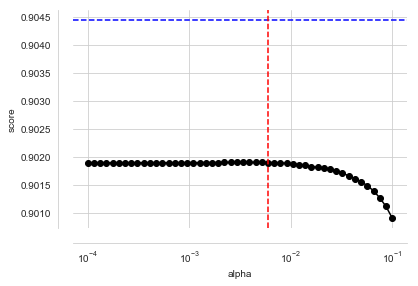

In [589]:
plt.plot(alphas, scores, '-ko')
plt.axhline(cv_score, color='b',ls='--')
plt.axvline(cv_alpha, color='r', ls='--')
plt.xlabel('alpha')
plt.ylabel('score')
plt.xscale('log')
sns.despine(offset=15)

In [590]:
predictions = lasso_cv.predict(X_test)

In [591]:
lasso_cv.score(x, y)

0.90444314333874742

In [592]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 1.64442685856
MSE: 5.55213606225
RMSE: 2.35629710823


In [593]:
np.amax(scores)

0.90190481082262264

In [594]:
np.take(alphas, np.argmax(scores))

0.003906939937054617

Text(0,0.5,'predictions')

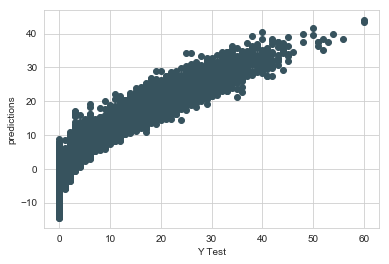

In [595]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('predictions')